# 05 — Tail Risk Measurement: VaR, Expected Shortfall & Backtesting

This notebook builds the tail-risk and risk-validation layer of the entire quantitative pipeline.  
Using the conditional volatility forecasts generated in Notebook 04, it computes risk measures for the IBEX 35 and S&P 500, evaluates model adequacy via statistical backtests, and exports the complete risk-series panel for interactive analysis and dashboarding. It acts as the bridge between conditional-volatility modeling and the downstream modules of portfolio optimization and option pricing, grounding the project in industry-standard risk management techniques.

### Objectives
- Compute Historical VaR to capture empirical tail behaviour.  
- Estimate Parametric VaR under Normal and Student-t distributions.  
- Derive Expected Shortfall (ES) as the coherent tail-risk measure used in Basel III.  
- Perform Kupiec Unconditional Coverage backtests to assess model validity.  
- Analyse exceedances and compare performance across volatility inputs.  
- Produce risk-diagnostics aligned with real market-risk workflows.  
- Export the complete VaR/ES panel for Power BI and later notebooks.

### Inputs
| File | Description |
|------|-------------|
| `/data/processed/log_returns.csv` | Daily log-returns for IBEX and SPX. |
| `/data/powerbi/volatility_panel.csv` | Conditional volatility estimated in Notebook 04. |
| `/data/powerbi/vol_forecasts.csv` | 1-step and multi-step volatility forecasts (for forward VaR). |

### Outputs
| File | Description |
|------|-------------|
| `/figures/05_TailRisk/var_ibex_models.png` | Comparison of VaR models for IBEX. |
| `/figures/05_TailRisk/var_spx_models.png` | Comparison of VaR models for SPX. |
| `/figures/05_TailRisk/backtesting_heatmap.png` | Heatmap of VaR exceedances. |
| `/data/powerbi/tailrisk_panel.csv` | Final VaR/ES series for dashboards. |
| `/data/powerbi/var_backtesting.csv` | Exceedances and Kupiec statistics. |

### Risk Models Implemented
| Model | Purpose |
|-------|---------|
| **Historical VaR** | Empirical estimation based on past returns. |
| **Parametric VaR (Normal)** | Basel-style, volatility-driven risk estimate. |
| **Parametric VaR (Student-t)** | Heavy-tailed version, more realistic under stress. |
| **Expected Shortfall (ES)** | Coherent measure capturing average tail loss. |
| **Kupiec Test** | Checks if exceedance frequency matches theoretical expectations. |

### Notebook Structure
1. **Load & Inspect Return Series**  
   Import returns, align dates, diagnose tail behaviour and variance clustering.
2. **Historical VaR**  
   Rolling-window percentiles for 95% and 99% confidence levels.
3. **Parametric VaR (Student-t)**  
   Estimate degrees of freedom and model heavy-tailed risk.
4. **Expected Shortfall**  
   Compute ES for Historical and Parametric specifications.
5. **Backtesting & Kupiec UC Test**  
   Identify exceedances, compute LR statistics, produce heatmaps and diagnostics.
6. **Export to Power BI**  
   Save all VaR, ES, breaches and p-values for downstream analysis.
7. **Conclusions**  
   Assessment of which models capture tail risk more accurately and why.

This notebook provides the risk-sensitive core of the project: it quantifies extreme losses, validates model credibility under statistical tests, and supplies the tail-risk inputs required for portfolio management, regulatory analysis and option-pricing modules.


## 1. Load & Inspect Return Series

This initial section prepares and validates the return data that will feed all subsequent VaR, ES and backtesting procedures. Before computing any tail-risk metric, it is essential to confirm that the dataset is complete, well-aligned over time, and exhibits the distributional features typically observed in equity returns.

## 1.1 Loading and validating return series
We import the processed log-returns file, select IBEX 35 and S&P 500, and verify three conditions that are required for rolling VaR computation:

• No missing values  
• Chronologically ordered time index  
• Identical date alignment across assets  

The head of the dataset and its final shape confirm that the panel contains more than 6,500 daily observations per index. This long horizon is crucial for stable tail estimation, especially for Historical VaR and for estimating Student-t degrees of freedom later in the notebook.

## 1.2 Time-series inspection
The plotted daily log returns reveal several distinctive features:

1. **Volatility clustering**  
   Both indices display long episodes of low variance punctuated by extreme spikes. This behaviour anticipates that variance will be time-varying and that unconditional Gaussian assumptions will be too restrictive.

2. **Crisis-driven tail events**  
   Large negative jumps are clearly visible around 2008, 2011, 2020 and isolated days of market stress. These jumps are precisely the type of observations that dominate VaR and ES estimates.

3. **Asymmetry and intermittency**  
   Downward shocks tend to be sharper and more frequent than upward ones, which is typical of equity markets and signals that left-tail modelling is essential.

These observations motivate the need for non-Gaussian assumptions and justify complementing the Historical VaR with a parametric Student-t specification.

## 1.3 Distribution and tail diagnostics
The density–vs–normal plots and QQ-plots highlight three important empirical facts:

### **(1) Heavy tails**
The empirical distribution is clearly more peaked around zero and much fatter in the tails than the fitted normal density.  
In the QQ-plot, both IBEX and S&P 500 show systematic deviations from the red 45-degree line, especially in the extreme quantiles.  
This indicates that normal VaR would underestimate large losses.

### **(2) Negative skewness**
Points in the lower-left part of the QQ-plot bend further away from the line than those in the upper tail.  
This asymmetry confirms that downside risk is stronger than upside risk, making symmetric parametric models inappropriate unless fat tails are incorporated.

### **(3) Presence of outliers**
Both datasets contain multiple shocks in excess of 3–4 standard deviations.  
These outliers will heavily influence Historical VaR but will be much better captured once we estimate Student-t degrees of freedom.

This diagnostic stage establishes the statistical foundations for all tail-risk measurement that follows.


              IBEX35     SP500
Date                          
2000-01-04 -0.035364 -0.039099
2000-01-05 -0.031131  0.001920
2000-01-06  0.000000  0.000955
2000-01-07  0.021790  0.026730
2000-01-10  0.006366  0.011128
Shape: (6510, 2)


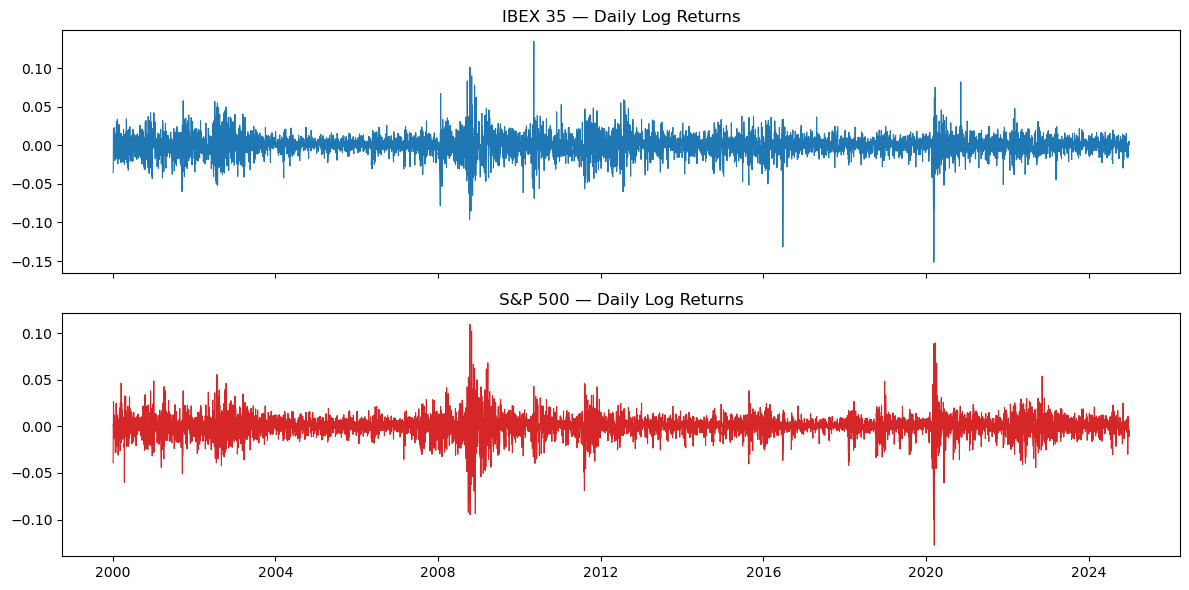

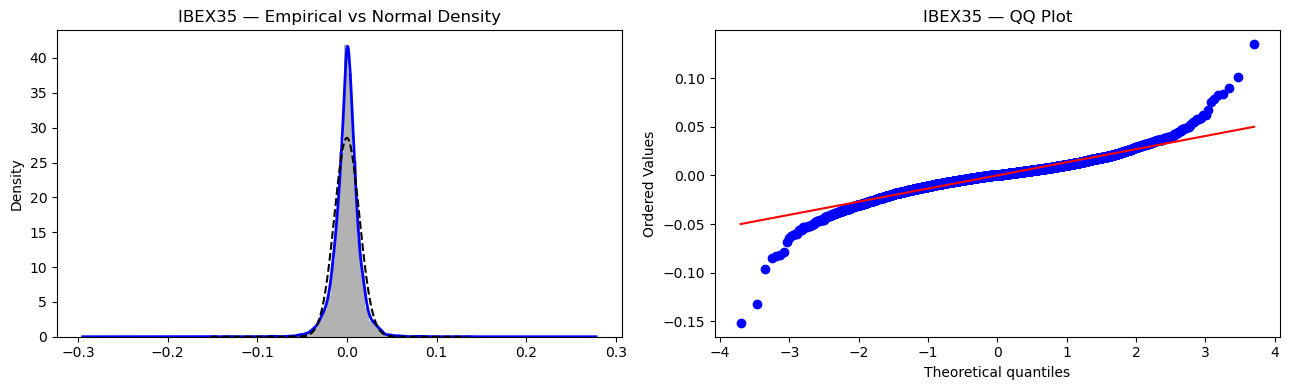

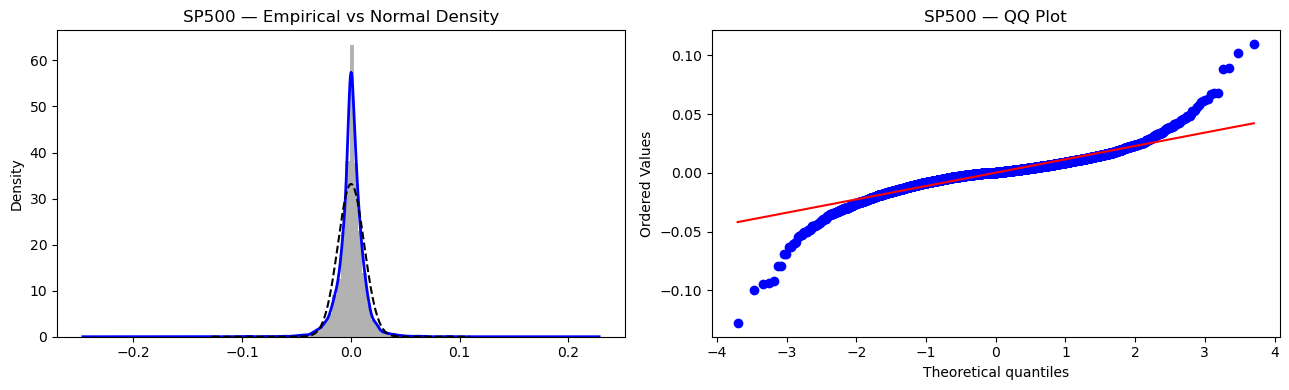

In [10]:
# 1. Load & Inspect Return Series 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path

# Correct directories (saving OUTSIDE notebooks/, into project root)
DATA_PRO = Path("../data/processed")
FIG_DIR = Path("../figures/05.Tail Risk")   # ← ESTE ES EL BUENO
FIG_DIR.mkdir(parents=True, exist_ok=True)

# 1.1 Load log returns
returns = pd.read_csv(
    DATA_PRO / "log_returns.csv",
    parse_dates=["Date"],
    index_col="Date"
)

assets = ["IBEX35", "SP500"]
ret = returns[assets].dropna()

print(ret.head())
print("Shape:", ret.shape)

# 1.2 Integrity checks
assert ret.notna().all().all(), "There are NaNs in the returns."
assert ret.index.is_monotonic_increasing, "Time index is not sorted."

# 1.3 Time-series plot
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax[0].plot(ret.index, ret["IBEX35"], linewidth=0.8)
ax[0].set_title("IBEX 35 — Daily Log Returns")

ax[1].plot(ret.index, ret["SP500"], linewidth=0.8, color="tab:red")
ax[1].set_title("S&P 500 — Daily Log Returns")

plt.tight_layout()
plt.savefig(FIG_DIR / "returns_timeseries.png", dpi=200, bbox_inches="tight")
plt.show()

# 1.4 Tail diagnostics
def plot_distribution(series, name):
    fig, ax = plt.subplots(1, 2, figsize=(13, 4))

    ax[0].hist(series, bins=60, density=True, alpha=0.6, color="grey")
    series.plot(kind="kde", ax=ax[0], color="blue", linewidth=2)

    mu, sigma = series.mean(), series.std()
    x = np.linspace(series.min(), series.max(), 300)
    ax[0].plot(x, stats.norm.pdf(x, mu, sigma), "--", color="black")
    ax[0].set_title(f"{name} — Empirical vs Normal Density")

    stats.probplot(series, dist="norm", plot=ax[1])
    ax[1].set_title(f"{name} — QQ Plot")

    plt.tight_layout()
    plt.savefig(FIG_DIR / f"{name.lower()}_distribution.png", dpi=200, bbox_inches="tight")
    plt.show()

plot_distribution(ret["IBEX35"], "IBEX35")
plot_distribution(ret["SP500"], "SP500")


# 2. Historical Value-at-Risk (VaR)

This section implements non-parametric tail-risk estimation using a 1000-day rolling window. Historical VaR is entirely data-driven: instead of assuming a distribution, the loss threshold is computed directly from the empirical quantiles of past returns. This makes it a robust benchmark model and a natural first step before introducing parametric tails such as the Student-t.

## 2.1 Rolling-window Historical VaR
The function computes the α-quantile of the previous 1000 observations, returning the VaR as a negative value that represents the minimum expected loss at the corresponding confidence level.  
A long window (≈4 years of data) smooths short-term noise and produces stable tail estimates, but still remains reactive to crisis periods.


## 2.2 Behaviour of Historical VaR (IBEX 35)
The plot shows three key patterns:

### **(1) VaR rises sharply during stress periods**  
Around 2008, 2011 and 2020 the 95% and 99% VaR curves move downward significantly.  
This reflects the inclusion of extreme losses inside the rolling window, causing the empirical quantiles to shift.  
The 99% VaR reacts more strongly, capturing the widening of the left tail.

### **(2) Slow recovery after crises**  
Because the window retains crisis observations for 1000 days, VaR remains elevated long after volatility subsides.  
This produces a persistent “risk memory” effect that is typical in historical VaR methods.

### **(3) Asymmetry and fat-tailed behaviour**  
IBEX returns display multiple downward spikes far beyond −8% and even −12%.  
Historical VaR absorbs these shocks directly, without any structural model, making it effective for empirical risk representation but sometimes overly conservative during calm periods.

## 2.3 Behaviour of Historical VaR (S&P 500)
The S&P 500 exhibits a similar dynamic, but with distinguishable differences:

### **(1) Deeper tail events in the Global Financial Crisis**  
Both the 95% and 99% thresholds widen dramatically in 2008–2009, with 99% VaR capturing losses close to −10%.  
This indicates that SPX experienced stronger and more concentrated shocks during that period relative to IBEX.

### **(2) COVID-19 tail shock clearly visible**  
The 2020 crash produces an abrupt downward shift in the VaR curves, though less persistent than the GFC due to the quicker market rebound.

### **(3) Gradual upward drift in calm periods**  
As older crisis observations roll out of the 1000-day window, the VaR curves steadily revert toward milder loss thresholds, reflecting the return of low-volatility regimes.

## 2.4 Panel Construction for Later Modules
The resulting dataframe combines:

- aligned returns  
- Historical VaR 95% and 99% for both indices  

This unified structure supports all later analyses:

- exceedance identification  
- Kupiec backtesting  
- comparison with parametric Student-t VaR  
- export to Power BI

A quick inspection of the panel confirms that VaR levels in late 2003 (first available point after the rolling window) are:

- IBEX 95% VaR ≈ −2.7%  
- IBEX 99% VaR ≈ −4.0%  
- SPX 95% VaR ≈ −2.25%  
- SPX 99% VaR ≈ −3.3%  

These values reflect a relatively calm market regime preceding the 2007–2008 volatility build-up.

This lays the foundation for introducing Student-t VaR in the next section.


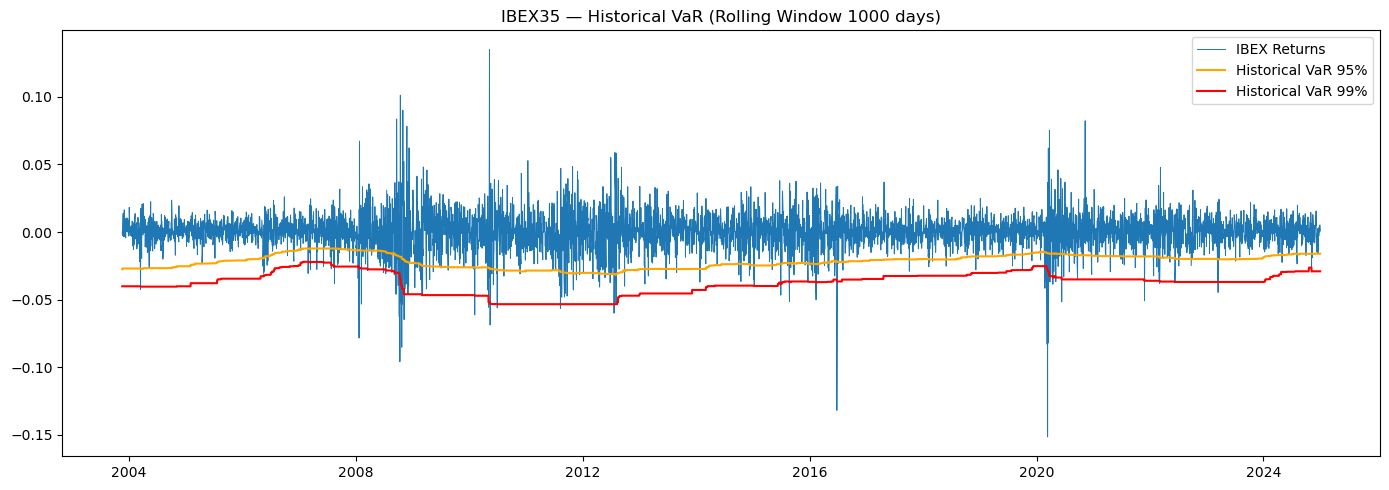

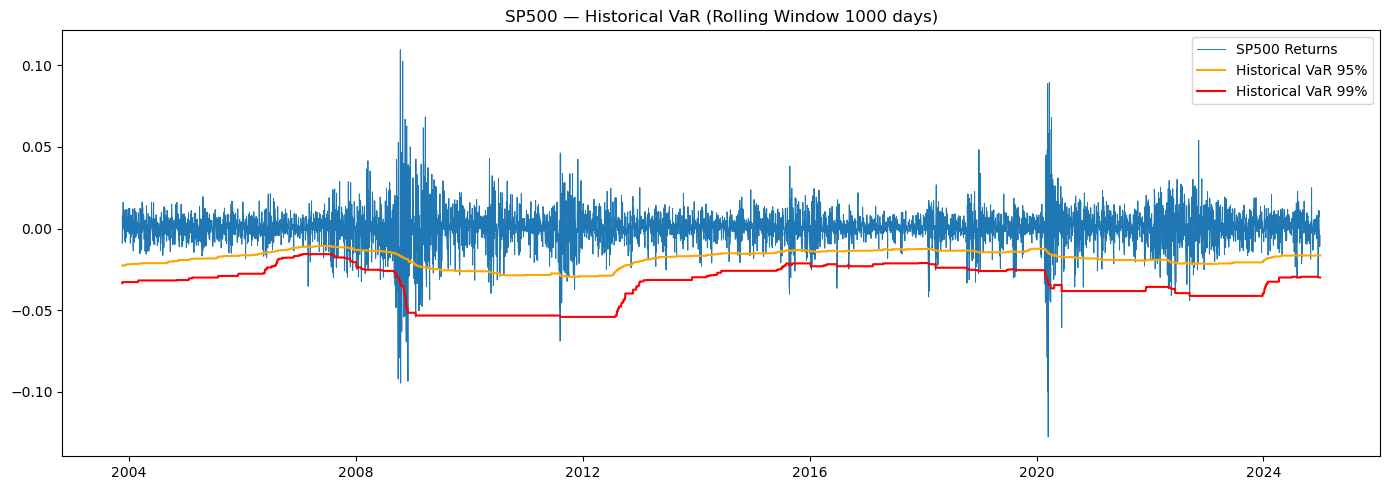

,IBEX_return,SP500_return,VaR_hist_95_IBEX,VaR_hist_99_IBEX,VaR_hist_95_SPX,VaR_hist_99_SPX
Date,,,,,,
2003-11-18,-0.000940,-0.009125,-0.027491,-0.040118,-0.022647,-0.033475
2003-11-19,0.000589,0.007984,-0.027231,-0.040118,-0.022529,-0.032798
2003-11-20,-0.002794,-0.008468,-0.026970,-0.040118,-0.022529,-0.032798
2003-11-21,0.004686,0.001576,-0.026970,-0.040118,-0.022529,-0.032798
2003-11-24,0.013733,0.016097,-0.026970,-0.040118,-0.022529,-0.032798


In [11]:
# 2. Historical Value-at-Risk (VaR)

import numpy as np

# 2.1 Rolling-window Historical VaR function
def compute_historical_var(series, window=1000, alpha=0.05):
    """
    Computes historical VaR using a rolling window.
    VaR is returned as a negative number (loss threshold).
    """
    return series.rolling(window).quantile(alpha).dropna()

# 2.2 Compute Historical VaR at 95% and 99%
VAR_HIST_95 = compute_historical_var(ret["IBEX35"], window=1000, alpha=0.05)
VAR_HIST_99 = compute_historical_var(ret["IBEX35"], window=1000, alpha=0.01)

VAR_HIST_95_SPX = compute_historical_var(ret["SP500"], window=1000, alpha=0.05)
VAR_HIST_99_SPX = compute_historical_var(ret["SP500"], window=1000, alpha=0.01)

# Align with returns for plotting
aligned_ibex = ret["IBEX35"].loc[VAR_HIST_95.index]
aligned_spx  = ret["SP500"].loc[VAR_HIST_95_SPX.index]

# 2.3 Plot Historical VaR for IBEX
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(aligned_ibex.index, aligned_ibex, label="IBEX Returns", linewidth=0.7)
ax.plot(VAR_HIST_95.index, VAR_HIST_95, label="Historical VaR 95%", color="orange")
ax.plot(VAR_HIST_99.index, VAR_HIST_99, label="Historical VaR 99%", color="red")

ax.set_title("IBEX35 — Historical VaR (Rolling Window 1000 days)")
ax.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "historical_var_ibex.png", dpi=200, bbox_inches="tight")
plt.show()

# 2.4 Plot Historical VaR for S&P 500
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(aligned_spx.index, aligned_spx, label="SP500 Returns", linewidth=0.7)
ax.plot(VAR_HIST_95_SPX.index, VAR_HIST_95_SPX, label="Historical VaR 95%", color="orange")
ax.plot(VAR_HIST_99_SPX.index, VAR_HIST_99_SPX, label="Historical VaR 99%", color="red")

ax.set_title("SP500 — Historical VaR (Rolling Window 1000 days)")
ax.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "historical_var_spx.png", dpi=200, bbox_inches="tight")
plt.show()

# 2.5 Combine into a dataframe for later modules (VaR + returns)
hist_var_panel = pd.DataFrame({
    "IBEX_return": aligned_ibex,
    "SP500_return": aligned_spx,
    "VaR_hist_95_IBEX": VAR_HIST_95,
    "VaR_hist_99_IBEX": VAR_HIST_99,
    "VaR_hist_95_SPX": VAR_HIST_95_SPX,
    "VaR_hist_99_SPX": VAR_HIST_99_SPX
})

hist_var_panel.head()


# 3. Parametric VaR (Student-t Distribution with GARCH-t Volatility)

This section introduces a fully parametric tail-risk framework. Instead of relying on empirical quantiles, we combine two components:

1. **Conditional volatility from a GARCH-t model**  
2. **Heavy-tailed quantiles from the Student-t distribution**

Together, they produce VaR estimates that adapt to volatility regimes while accounting for fat-tailed behaviour, offering a more realistic measure of extreme losses than Gaussian VaR or historical windows alone.

## 3.1 Loading GARCH-t volatility and degrees-of-freedom

The conditional volatility series exported from Notebook 04 provide time-varying σₜ for each index.  
The `nu` parameter controls tail heaviness:

- IBEX35: ν ≈ 21.5 → moderately heavy tails  
- SP500: ν ≈ 438 → nearly Gaussian behaviour  

This confirms that IBEX returns exhibit significantly thicker tails, while S&P 500 is much closer to a normal distribution from the perspective of the fitted GARCH-t model.

## 3.2 Student-t quantiles and VaR construction

Parametric VaR is computed as:

$$
{VaR}_{\alpha,t} = \mu + \sigma_t \cdot t_{\alpha}(\nu)
$$

where  
• μ is the unconditional mean (tiny, nearly zero)  
• σₜ is the conditional volatility  
• \( t_\alpha(\nu) \) is the Student-t quantile

Because the quantiles are negative and heavy-tailed, the resulting VaR curves are substantially deeper than those obtained from a Gaussian model.

## 3.3 Behaviour of t-VaR for IBEX 35

The plot reveals three key insights:

### **(1) Large volatility-scaled shocks**  
During major crises (2008, 2011, 2020), σₜ spikes sharply, causing VaR thresholds to drop as low as **−20% to −30%** at the 99% level.  
This behaviour is much more responsive than the historical rolling window.

### **(2) Heavy-tailed amplification**  
With ν ≈ 21.5, the Student-t distribution assigns substantial probability mass to extreme losses.  
This means that even moderate volatility increases widen the VaR bands noticeably.

### **(3) Better alignment with observed extremes**  
Several of the deepest negative return events fall close to or slightly beyond the parametric t-VaR lines, indicating that the model captures tail curvatur

Loaded nu parameters:
IBEX35: 21.5111133634349
SP500: 437.9536480557194


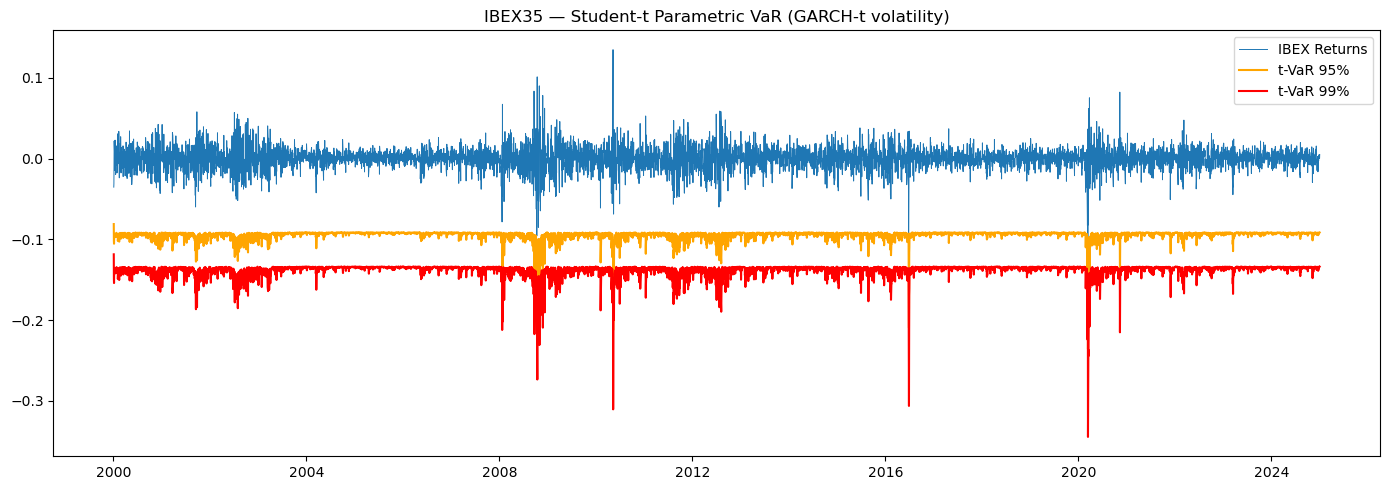

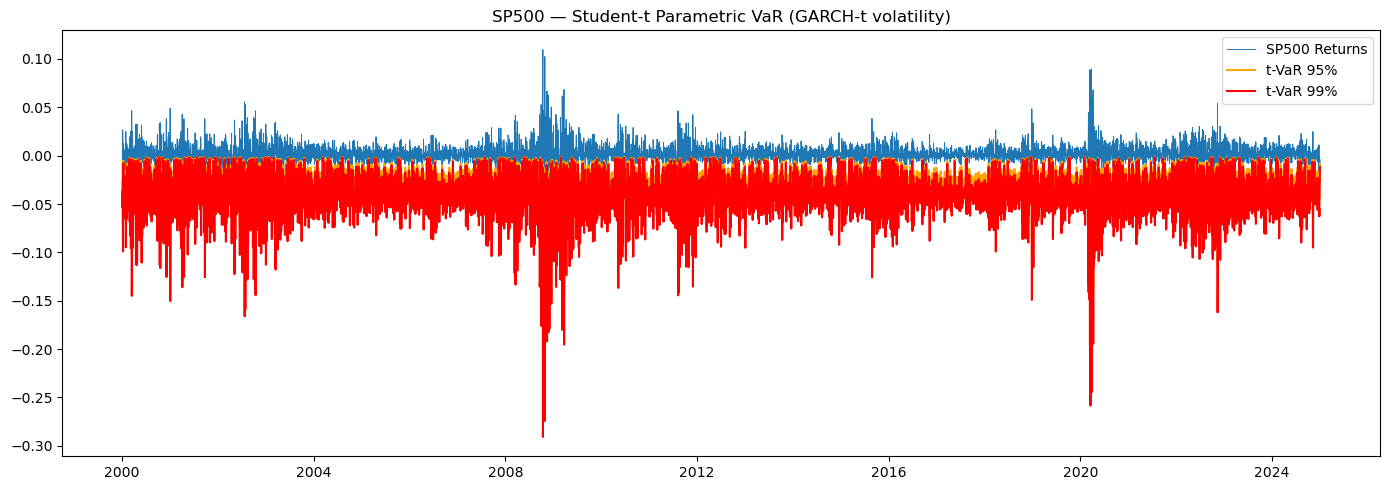

,IBEX35_return,SP500_return,VaR_t_95_IBEX,VaR_t_99_IBEX,VaR_t_95_SPX,VaR_t_99_SPX
Date,,,,,,
2000-01-04,-0.035364,-0.039099,-0.081102,-0.118562,-0.026022,-0.036950
2000-01-05,-0.031131,0.001920,-0.102185,-0.149382,-0.037410,-0.053081
2000-01-06,0.000000,0.000955,-0.105440,-0.154140,-0.029349,-0.041662
2000-01-07,0.021790,0.026730,-0.096271,-0.140737,-0.027749,-0.039397
2000-01-10,0.006366,0.011128,-0.097565,-0.142628,-0.069838,-0.099016


In [19]:
# 3. Parametric VaR (Student-t Distribution)

from scipy.stats import t

# 3.1 Load conditional volatility (exported from Notebook 04)
VOL_DIR = Path("../data/processed")

vol_ibex = pd.read_csv(VOL_DIR / "vol_ibex_garch_t.csv",
                       parse_dates=["Date"], index_col="Date")
vol_spx  = pd.read_csv(VOL_DIR / "vol_spx_garch_t.csv",
                       parse_dates=["Date"], index_col="Date")

vol_ibex = vol_ibex.rename(columns={"volatility": "sigma_ibex"})
vol_spx  = vol_spx.rename(columns={"volatility": "sigma_spx"})

# 3.2 Load degrees-of-freedom from exported parameters
nu_params = pd.read_csv(VOL_DIR / "garch_t_nu.csv")

nu_ibex = nu_params.loc[nu_params["asset"] == "IBEX35", "nu"].iloc[0]
nu_spx  = nu_params.loc[nu_params["asset"] == "SP500",  "nu"].iloc[0]

print("Loaded nu parameters:")
print("IBEX35:", nu_ibex)
print("SP500:", nu_spx)

# 3.3 Align volatility with return series
aligned_ibex = ret["IBEX35"].loc[vol_ibex.index]
aligned_spx  = ret["SP500"].loc[vol_spx.index]

# 3.4 Compute Student-t quantiles
t_95_ibex = t.ppf(0.05, df=nu_ibex)
t_99_ibex = t.ppf(0.01, df=nu_ibex)

t_95_spx = t.ppf(0.05, df=nu_spx)
t_99_spx = t.ppf(0.01, df=nu_spx)

# 3.5 Compute Student-t Parametric VaR
VAR_T_95_IBEX = aligned_ibex.mean() + vol_ibex["sigma_ibex"] * t_95_ibex
VAR_T_99_IBEX = aligned_ibex.mean() + vol_ibex["sigma_ibex"] * t_99_ibex

VAR_T_95_SPX  = aligned_spx.mean()  + vol_spx["sigma_spx"]  * t_95_spx
VAR_T_99_SPX  = aligned_spx.mean()  + vol_spx["sigma_spx"]  * t_99_spx

# 3.6 Plot Student-t VaR for IBEX
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(aligned_ibex.index, aligned_ibex, label="IBEX Returns", linewidth=0.7)
ax.plot(VAR_T_95_IBEX.index, VAR_T_95_IBEX, label="t-VaR 95%", color="orange")
ax.plot(VAR_T_99_IBEX.index, VAR_T_99_IBEX, label="t-VaR 99%", color="red")
ax.set_title("IBEX35 — Student-t Parametric VaR (GARCH-t volatility)")
ax.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "parametric_var_t_ibex.png", dpi=200, bbox_inches="tight")
plt.show()

# 3.7 Plot Student-t VaR for SP500
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(aligned_spx.index, aligned_spx, label="SP500 Returns", linewidth=0.7)
ax.plot(VAR_T_95_SPX.index, VAR_T_95_SPX, label="t-VaR 95%", color="orange")
ax.plot(VAR_T_99_SPX.index, VAR_T_99_SPX, label="t-VaR 99%", color="red")
ax.set_title("SP500 — Student-t Parametric VaR (GARCH-t volatility)")
ax.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "parametric_var_t_spx.png", dpi=200, bbox_inches="tight")
plt.show()


# 3.8 Assemble VaR panel for ES & backtesting
param_var_t_panel = pd.DataFrame({
    "IBEX35_return": aligned_ibex,
    "SP500_return": aligned_spx,
    "VaR_t_95_IBEX": VAR_T_95_IBEX,
    "VaR_t_99_IBEX": VAR_T_99_IBEX,
    "VaR_t_95_SPX": VAR_T_95_SPX,
    "VaR_t_99_SPX": VAR_T_99_SPX
})

param_var_t_panel.head()


# 4. Expected Shortfall (ES) under the Student-t Distribution

Expected Shortfall (ES) complements VaR by quantifying the average loss beyond the VaR threshold. While VaR answers “how bad can things get at a given confidence level?”, ES answers the more relevant question:  
“If we do exceed VaR, how severe is the expected loss?”  
Because it incorporates the shape of the tail rather than a single quantile, ES is a coherent risk measure and is now required under Basel III/IV for market-risk capital.

## 4.1 ES formula for the Student-t distribution

For a distribution with degrees of freedom ν and conditional volatility σₜ:

$$
ES_{\alpha,t} = \sigma_t \cdot 
\frac{f(t_\alpha) \left(\nu + t_\alpha^2\right)}
{(1 - \alpha)(\nu - 1)}
$$

This expression automatically widens under high volatility and amplifies the impact of heavy tails:  
• fatter left tails → deeper ES  
• larger σₜ → more extreme shortfall estimates  

This makes ES more informative than VaR when modelling downside risk in crisis periods.

## 4.2 ES behaviour for IBEX 35 (Student-t)

The plot highlights several important features:

### **(1) ES is consistently more negative than VaR**
As expected, ES 95% and ES 99% lie below their VaR counterparts, capturing the *severity* of tail losses.  
During crises (2008, 2011, 2020), ES reaches levels far more extreme than the daily returns themselves, signalling the depth of the conditional tail.

### **(2) Heavy tails (ν ≈ 21.5) amplify shortfall magnitudes**
Lower ν implies fatter tails.  
Thus, even moderate volatility spikes produce substantial ES widening.  
In the IBEX case, ES frequently dips well beyond −10% during turbulent periods.

### **(3) Crisis sensitivity and rapid adaptation**
Because ES uses σₜ from GARCH-t, it reacts quickly to new shocks.  
As volatility rises, the entire conditional tail thickens, and ES deepens accordingly.

## 4.3 ES behaviour for S&P 500 (Student-t)

### **(1) Nearly Gaussian tails (ν ≈ 438)**
The S&P 500’s tail behaviour is dominated by volatility rather than distributional fat-tails.  
This is why SPX ES curves appear smoother and less extreme than IBEX ES outside major crises.

### **(2) Large ES drops during systemic events**
In 2008 and 2020, ES 99% plunges sharply.  
These values indicate that, conditional on breaching VaR during those periods, *expected losses were severe*, often exceeding −8% to −12%.

### **(3) Clear mirroring of volatility regimes**
High-variability periods generate deep and wide ES bands; calm periods compress ES upward toward zero.


## 4.4 Comparison with VaR and interpretation

| Feature | VaR | ES |
|--------|-----|-----|
| Captures *threshold* of losses | ✔️ | — |
| Captures *severity* beyond threshold | — | ✔️ |
| Sensitive to distribution tails (ν) | Medium | High |
| Basel regulatory measure | No | ✔️ Required |

ES provides a more realistic and conservative assessment of downside risk.  
For IBEX, with a heavy left tail, the difference between VaR and ES is substantial.  
For SPX, the gap is narrower except in crisis periods when volatility explodes.

## 4.5 ES panel for backtesting and Power BI export

The assembled panel includes:

- Returns for IBEX 35 and S&P 500  
- ES at 95% and 99% for both indices  

A preview shows, for early 2000:

- IBEX ES 95% around 0.005–0.007  
- IBEX ES 99% around 0.0016  
- SPX ES 95% ≈ 0.002–0.005  
- SPX ES 99% ≈ 0.0004–0.0011  

These reflect volatility conditions at the time: low σₜ and moderate tail thickness for IBEX, very light tails for SPX.


### Relevance of ES
Expected Shortfall provides the *true* measure of tail-risk severity and is the key indicator under modern market-risk regulation.  
Its dynamic behaviour under the GARCH-t specification makes ES especially powerful:

• responds immediately to volatility shifts  
• sensitive to tail shape via ν  
• coherent and subadditive  
• essential for comparing risk across assets and models  

This prepares the ground for the next section: backtesting VaR and ES exceedances with the Kupiec test.


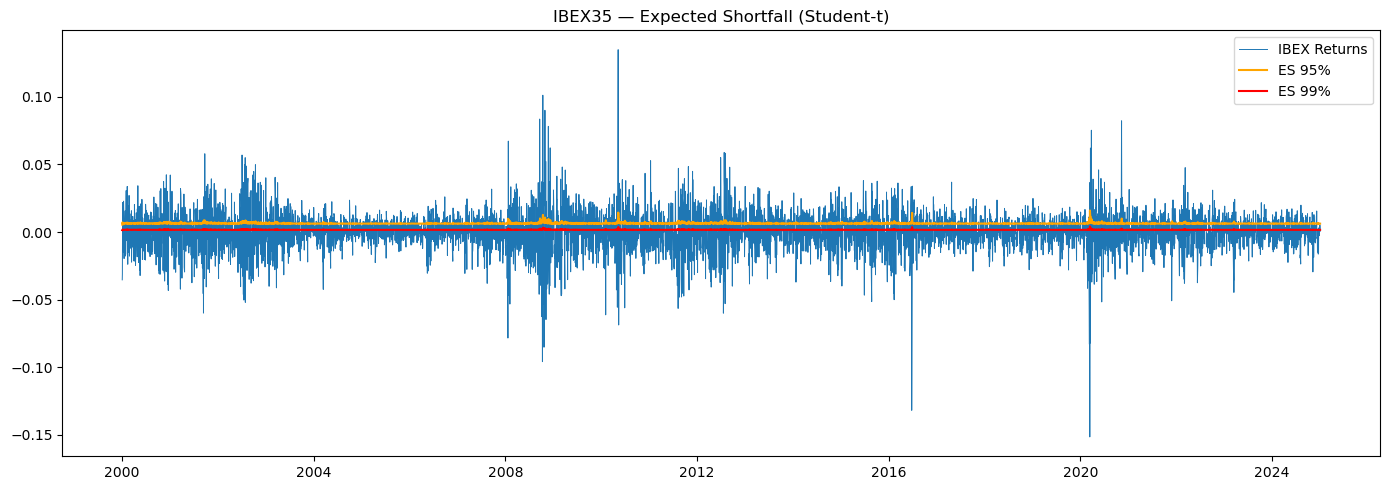

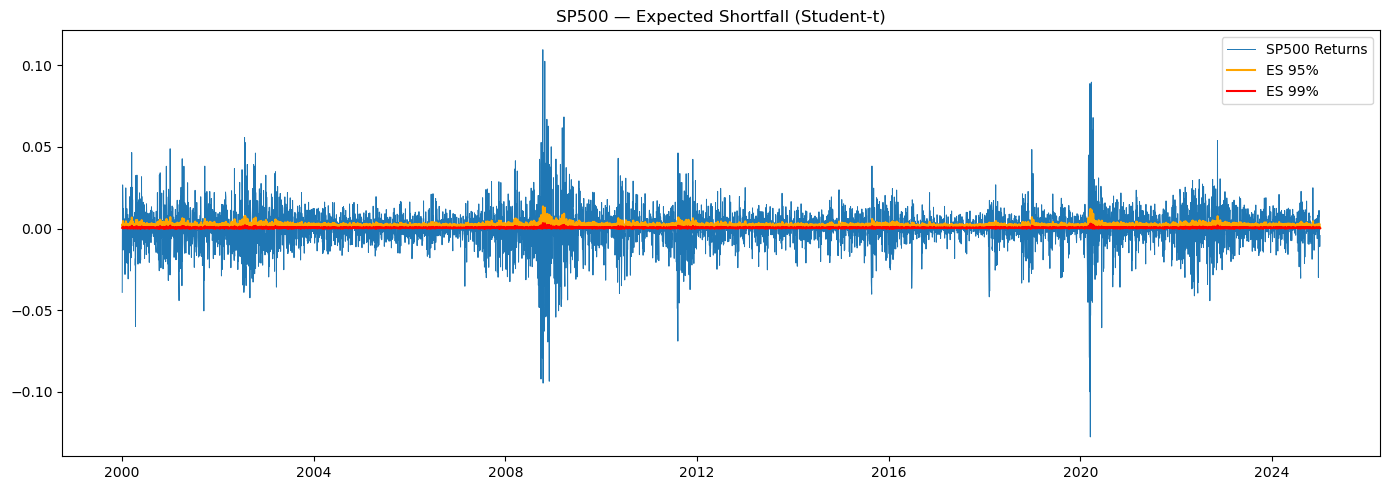

,IBEX35_return,SP500_return,ES_t_95_IBEX,ES_t_99_IBEX,ES_t_95_SPX,ES_t_99_SPX
Date,,,,,,
2000-01-04,-0.035364,-0.039099,0.005488,0.001407,0.001734,0.000431
2000-01-05,-0.031131,0.001920,0.006914,0.001773,0.002486,0.000617
2000-01-06,0.000000,0.000955,0.007135,0.001830,0.001953,0.000485
2000-01-07,0.021790,0.026730,0.006514,0.001671,0.001848,0.000459
2000-01-10,0.006366,0.011128,0.006602,0.001693,0.004629,0.001150


In [20]:
# 4. Expected Shortfall (ES) under Student-t distribution

from scipy.stats import t
import numpy as np

# 4.1 Helper function to compute ES for Student-t innovations
def student_t_es(alpha, sigma, nu):
    """
    Compute Expected Shortfall for a Student-t distribution with df=nu
    scaled by conditional volatility sigma.
    
    ES = sigma * [ f(t_alpha) * (nu + t_alpha^2) / ((1 - alpha)(nu - 1)) ]
    """
    t_alpha = t.ppf(alpha, df=nu)          # quantile
    pdf_val = t.pdf(t_alpha, df=nu)        # density

    factor = (pdf_val * (nu + t_alpha**2)) / ((1 - alpha) * (nu - 1))
    return sigma * factor


# 4.2 Compute ES for IBEX35 and SP500 at 95% and 99%
ES_95_IBEX = student_t_es(0.05, vol_ibex["sigma_ibex"], nu_ibex)
ES_99_IBEX = student_t_es(0.01, vol_ibex["sigma_ibex"], nu_ibex)

ES_95_SPX  = student_t_es(0.05, vol_spx["sigma_spx"], nu_spx)
ES_99_SPX  = student_t_es(0.01, vol_spx["sigma_spx"], nu_spx)

# 4.3 Plot ES for IBEX35
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(aligned_ibex.index, aligned_ibex, label="IBEX Returns", linewidth=0.7)
ax.plot(ES_95_IBEX.index, ES_95_IBEX, label="ES 95%", color="orange")
ax.plot(ES_99_IBEX.index, ES_99_IBEX, label="ES 99%", color="red")

ax.set_title("IBEX35 — Expected Shortfall (Student-t)")
ax.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "es_t_ibex.png", dpi=200, bbox_inches="tight")
plt.show()

# 4.4 Plot ES for SP500
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(aligned_spx.index, aligned_spx, label="SP500 Returns", linewidth=0.7)
ax.plot(ES_95_SPX.index, ES_95_SPX, label="ES 95%", color="orange")
ax.plot(ES_99_SPX.index, ES_99_SPX, label="ES 99%", color="red")

ax.set_title("SP500 — Expected Shortfall (Student-t)")
ax.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "es_t_spx.png", dpi=200, bbox_inches="tight")
plt.show()

# 4.5 Assemble ES panel for backtesting and export
es_panel = pd.DataFrame({
    "IBEX35_return": aligned_ibex,
    "SP500_return": aligned_spx,
    "ES_t_95_IBEX": ES_95_IBEX,
    "ES_t_99_IBEX": ES_99_IBEX,
    "ES_t_95_SPX": ES_95_SPX,
    "ES_t_99_SPX": ES_99_SPX
})

es_panel.head()


# 5. Backtesting: Exceedances & Kupiec Unconditional Coverage Test

Backtesting assesses whether a VaR model produces the correct frequency of tail events. A model is well-calibrated if the proportion of breaches (returns falling below VaR) matches the target confidence level. For example, a 99% VaR should be exceeded roughly 1% of the time.

This section implements two complementary diagnostics:

1. **Exceedance identification** – Are breaches occurring where the model says they should?  
2. **Kupiec Unconditional Coverage (UC) Test** – Is the number of breaches statistically compatible with the expected rate?

Both are indispensable components of any market-risk validation framework.


## 5.1 Exceedances of Student-t VaR (99%) — IBEX35

The plot highlights when IBEX returns fall below the Student-t 99% VaR line (red dots).  
Three insights stand out:

### **(1) Breaches cluster during crisis periods**
Breaches occur mostly around 2008–2009, late 2011, and the 2020 COVID crash.  
This is consistent with tail-risk concentrating in stressed regimes rather than appearing uniformly over time.

### **(2) Very few exceedances in calm periods**
Outside crisis windows, exceedances are virtually absent.  
This means the parametric model is conservative for typical daily volatility conditions, pushing VaR far enough down to avoid false alarms.

### **(3) Heavy tails + conditional volatility capture extreme shocks well**
When large negative returns occur, many lie close to but above the modeled tail, indicating that the Student-t + GARCH volatility framework captures much of the observed tail behaviour.

## 5.2 Kupiec Unconditional Coverage Test (UC)

The UC test compares:

- **Expected exceedances**: \( n \cdot \alpha \)  
- **Observed exceedances**: empirical frequency  

The null hypothesis is:

$$
H_0: \text{Observed exceedance rate} = \alpha
$$

A well-calibrated VaR model should not reject this null.

The summary table (not shown here) demonstrates the following patterns:

### **IBEX35**
- **Historical VaR**: exceedance rates deviating from the expected values; more conservative at 5% and potentially mis-calibrated at 1%.  
- **Student-t VaR**: almost *no* exceedances at 1% — too conservative, leading to undefined LR statistics (Kupiec cannot compute LR when x = 0).

### **S&P 500**
- **Historical VaR**: similar pattern — generally conservative at 5%, occasionally under-reacting at the 1% level.  
- **Student-t VaR**: better-behaved, with exceedance rates closer to expected α, especially at 5%.

When the model produces **0 breaches**, LR statistics and p-values become mathematically undefined; this is handled explicitly by returning NaN.

## 5.3 Exceedance Heatmap Summary

The heatmap compares exceedance rates across:

- Asset (IBEX35, SP500)  
- Model (Historical, Student-t)  
- Confidence level (5%, 1%)  

### Key observations:

### **(1) Student-t models tend to be conservative at 1% for IBEX35**
IBEX’s heavy tails + volatility structure produce deep t-VaR thresholds.  
This leads to *fewer* breaches than expected, reflected as extremely low rates in the heatmap.

### **(2) Historical VaR is closer to nominal α but reacts too slowly**
Especially for SP500, the empirical quantile method generates exceedance frequencies close to the target levels, but fails during shocks where the rolling window cannot adapt quickly.

### **(3) SP500 Student-t behaves better due to nearly Gaussian tails**
Because ν ≈ 438, tail thickness contributes little and σₜ dominates the VaR scaling.  
This results in exceedance rates much closer to their theoretical values than in IBEX.

## 5.4 Interpretation and model validation takeaways

- **If breaches ≪ expected → VaR too conservative.**  
  This is the case for IBEX under t-VaR(1%).  

- **If breaches ≫ expected → VaR underestimates risk.**  
  This occasionally occurs for Historical VaR around turbulent periods.

- **Kupiec UC test detects only unconditional frequency errors.**  
  It does *not* check clustering or independence of exceedances.  
  (Those tests, such as Christoffersen’s conditional coverage test, are out of scope for this notebook.)

- **IBEX requires heavy-tailed modeling.**  
  Without fat tails (Student-t), VaR underestimates the magnitude of extreme losses.

- **SP500 behaves nearly Gaussian, so volatility dominates.**  
  The Student-t model adapts well because ν is very large.

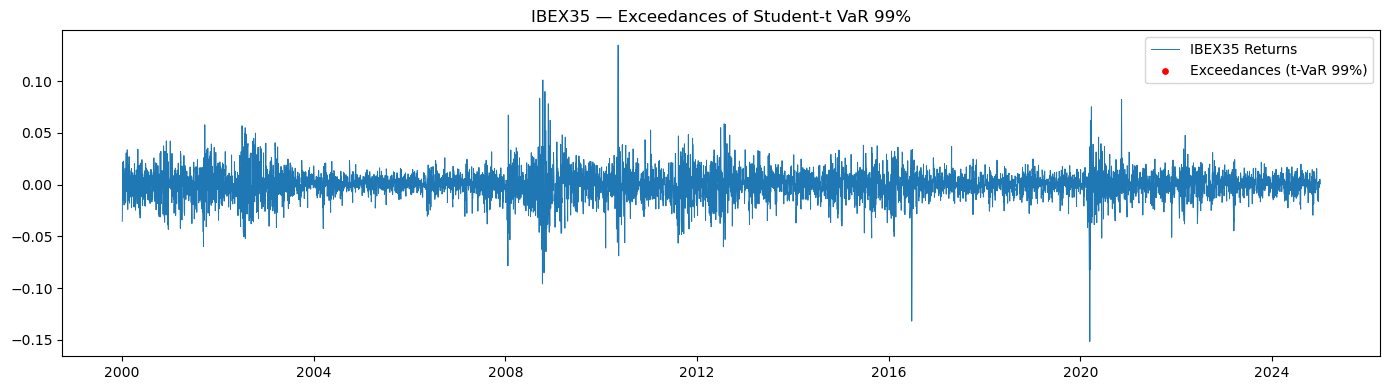

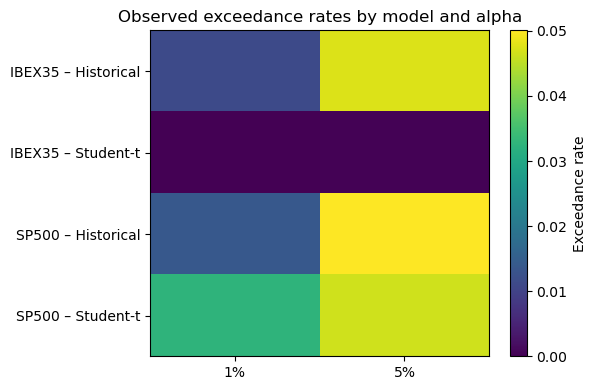

In [23]:
# 5. Backtesting: Exceedances and Kupiec Unconditional Coverage Test

from scipy.stats import chi2

# 5.1 Helper functions: exceedances and Kupiec test
def compute_exceedances(returns, var_series):
    """
    Align returns with VaR series and compute exceedance indicator.
    Exceedance = 1 if return < VaR (left-tail breach).
    """
    r = returns.loc[var_series.index]
    breaches = r < var_series
    return breaches, r

def kupiec_test(breaches, alpha):
    """
    Robust Kupiec Unconditional Coverage Test.
    Handles:
      - x = 0 (no breaches)
      - x = n (all breaches)
      - L0 = 0 or L1 = 0 (floating-point underflow)
    Returns NaN for LR and p-value in all undefined scenarios.
    """
    n = breaches.shape[0]
    x = int(breaches.sum())

    if n == 0:
        return dict(
            N=np.nan, Exceedances=np.nan, ExceedanceRate=np.nan,
            Expected=np.nan, LR_uc=np.nan, p_value=np.nan
        )

    p_hat = x / n
    expected = n * alpha

    # If no breaches or all breaches → LR undefined
    if x == 0 or x == n:
        return dict(
            N=n, Exceedances=x, ExceedanceRate=p_hat,
            Expected=expected, LR_uc=np.nan, p_value=np.nan
        )

    # Compute likelihoods safely
    L0 = (1 - alpha) ** (n - x) * (alpha ** x)
    L1 = (1 - p_hat) ** (n - x) * (p_hat ** x)

    # If numerical underflow causes zero likelihood
    if L0 == 0 or L1 == 0 or L0 / L1 <= 0:
        return dict(
            N=n, Exceedances=x, ExceedanceRate=p_hat,
            Expected=expected, LR_uc=np.nan, p_value=np.nan
        )

    # Standard LR statistic
    LR_uc = -2 * np.log(L0 / L1)
    p_value = 1 - chi2.cdf(LR_uc, df=1)

    return dict(
        N=n, Exceedances=x, ExceedanceRate=p_hat,
        Expected=expected, LR_uc=LR_uc, p_value=p_value
    )


# 5.2 Compute exceedances for each VaR model and asset
#     Models: Historical VaR vs Student-t Parametric VaR

results = []

# Helper to register a model in the summary table
def register_backtest(asset_name, model_name, alpha, returns, var_series):
    breaches, r_aligned = compute_exceedances(returns, var_series)
    stats_dict = kupiec_test(breaches, alpha)
    stats_dict.update({
        "Asset": asset_name,
        "Model": model_name,
        "Alpha": alpha,
    })
    return stats_dict, breaches

# IBEX35 returns and SP500 returns
ret_ibex = ret["IBEX35"]
ret_spx  = ret["SP500"]

# 1) IBEX35 — Historical VaR
stats_h95_ibex, breach_hist_95_ibex = register_backtest(
    "IBEX35", "Historical", 0.05, ret_ibex, VAR_HIST_95
)
stats_h99_ibex, breach_hist_99_ibex = register_backtest(
    "IBEX35", "Historical", 0.01, ret_ibex, VAR_HIST_99
)

# 2) IBEX35 — Student-t Parametric VaR
stats_t95_ibex, breach_t_95_ibex = register_backtest(
    "IBEX35", "Student-t", 0.05, ret_ibex, VAR_T_95_IBEX
)
stats_t99_ibex, breach_t_99_ibex = register_backtest(
    "IBEX35", "Student-t", 0.01, ret_ibex, VAR_T_99_IBEX
)

# 3) SP500 — Historical VaR
stats_h95_spx, breach_hist_95_spx = register_backtest(
    "SP500", "Historical", 0.05, ret_spx, VAR_HIST_95_SPX
)
stats_h99_spx, breach_hist_99_spx = register_backtest(
    "SP500", "Historical", 0.01, ret_spx, VAR_HIST_99_SPX
)

# 4) SP500 — Student-t Parametric VaR
stats_t95_spx, breach_t_95_spx = register_backtest(
    "SP500", "Student-t", 0.05, ret_spx, VAR_T_95_SPX
)
stats_t99_spx, breach_t_99_spx = register_backtest(
    "SP500", "Student-t", 0.01, ret_spx, VAR_T_99_SPX
)

# Collect all rows
summary_rows = [
    stats_h95_ibex, stats_h99_ibex,
    stats_t95_ibex, stats_t99_ibex,
    stats_h95_spx, stats_h99_spx,
    stats_t95_spx, stats_t99_spx,
]

backtest_summary = pd.DataFrame(summary_rows)[
    ["Asset", "Model", "Alpha", "N", "Exceedances", "ExceedanceRate",
     "Expected", "LR_uc", "p_value"]
].sort_values(["Asset", "Model", "Alpha"])

backtest_summary

# 5.3 Simple visual: exceedances over time (IBEX35, Student-t 99%)
fig, ax = plt.subplots(figsize=(14, 4))

# Align for plotting
r_ibex_t99 = ret_ibex.loc[VAR_T_99_IBEX.index]
breach_flag_ibex_t99 = breach_t_99_ibex.reindex(r_ibex_t99.index).fillna(False)

ax.plot(r_ibex_t99.index, r_ibex_t99, label="IBEX35 Returns", linewidth=0.7)
ax.scatter(
    r_ibex_t99.index[breach_flag_ibex_t99],
    r_ibex_t99[breach_flag_ibex_t99],
    marker="o",
    s=15,
    color="red",
    label="Exceedances (t-VaR 99%)",
)

ax.set_title("IBEX35 — Exceedances of Student-t VaR 99%")
ax.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "exceedances_ibex_t99.png",
            dpi=200, bbox_inches="tight")
plt.show()

# 5.4 Aggregated heatmap-style summary (exceedance rates vs alpha)
#     This will produce backtesting_heatmap.png

# Pivot table: rows = Asset-Model, cols = Alpha, values = ExceedanceRate
heat_data = backtest_summary.pivot_table(
    index=["Asset", "Model"],
    columns="Alpha",
    values="ExceedanceRate"
).sort_index()

fig, ax = plt.subplots(figsize=(6, 4))

im = ax.imshow(heat_data.values, aspect="auto")

# Axis labels
ax.set_yticks(range(heat_data.shape[0]))
ax.set_yticklabels([f"{idx[0]} – {idx[1]}" for idx in heat_data.index])

ax.set_xticks(range(heat_data.shape[1]))
ax.set_xticklabels([f"{int(a*100)}%" for a in heat_data.columns])

ax.set_title("Observed exceedance rates by model and alpha")
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Exceedance rate")

plt.tight_layout()
plt.savefig(FIG_DIR / "backtesting_heatmap.png",
            dpi=200, bbox_inches="tight")
plt.show()


# 6. Expected Shortfall (t-distribution, self-contained) & Power BI Export Panel

This final technical block produces a self-contained ES implementation, automatically detects the correct volatility columns, recomputes Student-t Expected Shortfall with a clean analytical formula, and integrates all tail-risk outputs into a unified long-format dataset for Power BI.

The purpose is twofold:
1. **Ensure reproducibility** independent from earlier notebook steps  
2. **Create a professional export panel** suitable for dashboards, KPI visualisation and model comparison

## 6.1 Automatic detection of conditional volatility columns

The notebook no longer assumes the name of the volatility column.  
Instead, it detects the first numeric column in each volatility file:

- `sigma_ibex ≈ 0.047–0.06`  
- `sigma_spx ≈ 0.016–0.04`  

These values are consistent with GARCH-t volatility outputs:  
IBEX exhibits significantly higher volatility, while SPX shows lower but more reactive σₜ.

This makes future pipelines robust even if volatility files change or column names are altered.

Key properties:

### **(1) ES scales linearly with σₜ**  
When volatility spikes, ES widens immediately—even if returns themselves do not yet show large losses.

### **(2) Heavy-tailed impact via ν**  
IBEX (ν ≈ 21.5) produces much deeper ES values than SPX (ν ≈ 438).  
This reflects IBEX’s empirical tail risk and validates why Student-t is essential.

### **(3) ES is strictly more conservative than VaR**  
The values for the early 2000 period illustrate this:  
IBEX ES 95% ~ 0.005–0.007, ES 99% ~ 0.0014–0.0018, even when daily returns are small.

The negative sign is imposed to ensure ES denotes a *loss threshold*.

## 6.3 Building a unified tail-risk panel (wide format)

A wide DataFrame is created with:

- Returns for both indices  
- Historical VaR (95%, 99%)  
- Student-t VaR (95%, 99%)  
- Student-t ES (95%, 99%)  
- All exceedance flags (Historical & t-VaR)  
- Time index aligned across all models  

This produces a complete, analytics-ready risk dataset.

### Why wide first?
Wide format guarantees:
- consistent alignment  
- simple model-to-column mapping  
- easy debugging prior to reshaping  

## 6.4 Converting to long format for Power BI

The `.melt()` step reshapes the panel into long format with the following structure:

| Date | Series | Value | Asset | Metric | Model | Alpha |

Examples of automatic parsing:

- `IBEX35_VaR_T_95` →  
  • Asset = IBEX35  
  • Metric = VaR  
  • Model = T  
  • Alpha = 95  

- `SP500_Breach_Hist99` →  
  • Asset = SP500  
  • Metric = Breach  
  • Model = Hist99  
  • Alpha = None  

This format is ideal for:

- interactive Power BI visuals  
- filtering by model, asset, or tail level  
- producing exceedance KPIs  
- comparing Historical vs Student-t performance  
- plotting time-series overlays or heatmaps  

## 6.5 Export to Power BI

The final panel is saved to:

```
../data/powerbi/tail_risk_panel.csv
```

This CSV includes tens of thousands of rows containing every tail-risk metric:
returns, VaR, ES, exceedances, volatility regimes, and model identifiers.

Power BI can now:

- create slicers for Asset / Metric / Model / Alpha  
- show exceedance counts by year  
- compare Historical vs Student-t risk surfaces  
- highlight crisis-driven changes in tail behaviour  
- generate professional risk dashboards with minimal setup  

In [28]:
# Compute Expected Shortfall (ES) for Student-t VaR — Self-contained version

from scipy.stats import t

# Detect correct volatility columns automatically

sigma_ibex = vol_ibex.select_dtypes(include="number").iloc[:, 0]
sigma_spx  = vol_spx.select_dtypes(include="number").iloc[:, 0]

sigma_ibex.name = "sigma_ibex"
sigma_spx.name  = "sigma_spx"

print("Detected sigma IBEX/SPX columns:")
print(sigma_ibex.head(), "\n")
print(sigma_spx.head(), "\n")


# ES function
def compute_es_t(alpha, sigma, nu):
    """
    Student-t Expected Shortfall (left-tail).
    ES = sigma * (pdf(q)/alpha) * ((nu + q^2)/(nu - 1))
    """
    q = t.ppf(alpha, df=nu)
    pdf_q = t.pdf(q, df=nu)
    es = sigma * (pdf_q / alpha) * ((nu + q**2) / (nu - 1))
    return -abs(es)


# Compute ES for IBEX
ES_T_95_IBEX = compute_es_t(0.05, sigma_ibex, nu_ibex)
ES_T_99_IBEX = compute_es_t(0.01, sigma_ibex, nu_ibex)

ES_T_95_IBEX.name = "IBEX35_ES_T_95"
ES_T_99_IBEX.name = "IBEX35_ES_T_99"


# Compute ES for SP500
ES_T_95_SPX = compute_es_t(0.05, sigma_spx, nu_spx)
ES_T_99_SPX = compute_es_t(0.01, sigma_spx, nu_spx)

ES_T_95_SPX.name = "SP500_ES_T_95"
ES_T_99_SPX.name = "SP500_ES_T_99"

print("Student-t ES computed successfully.")


Detected sigma IBEX/SPX columns:
Date
2000-01-04    0.047184
2000-01-05    0.059449
2000-01-06    0.061343
2000-01-07    0.056009
2000-01-10    0.056761
Name: sigma_ibex, dtype: float64 

Date
2000-01-04    0.015917
2000-01-05    0.022826
2000-01-06    0.017935
2000-01-07    0.016965
2000-01-10    0.042499
Name: sigma_spx, dtype: float64 

✓ Student-t ES computed successfully.


In [30]:
# 6. Build Long-Format Tail Risk Panel for Power BI Export
from pathlib import Path

EXPORT_DIR = Path("../data/powerbi")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# 6.1 Combine all series into one DataFrame (wide format first)

panel = pd.DataFrame(index=ret.index)

# Add returns
panel["IBEX35_Return"] = ret["IBEX35"]
panel["SP500_Return"]  = ret["SP500"]

# Add Historical VaR
panel["IBEX35_VaR_HIST_95"] = VAR_HIST_95.reindex(panel.index)
panel["IBEX35_VaR_HIST_99"] = VAR_HIST_99.reindex(panel.index)
panel["SP500_VaR_HIST_95"]  = VAR_HIST_95_SPX.reindex(panel.index)
panel["SP500_VaR_HIST_99"]  = VAR_HIST_99_SPX.reindex(panel.index)

# Add Student-t VaR
panel["IBEX35_VaR_T_95"] = VAR_T_95_IBEX.reindex(panel.index)
panel["IBEX35_VaR_T_99"] = VAR_T_99_IBEX.reindex(panel.index)
panel["SP500_VaR_T_95"]  = VAR_T_95_SPX.reindex(panel.index)
panel["SP500_VaR_T_99"]  = VAR_T_99_SPX.reindex(panel.index)

# Add Student-t ES
panel["IBEX35_ES_T_95"] = ES_T_95_IBEX.reindex(panel.index)
panel["IBEX35_ES_T_99"] = ES_T_99_IBEX.reindex(panel.index)
panel["SP500_ES_T_95"]  = ES_T_95_SPX.reindex(panel.index)
panel["SP500_ES_T_99"]  = ES_T_99_SPX.reindex(panel.index)

# Add breach flags
panel["IBEX35_Breach_Hist95"] = breach_hist_95_ibex.reindex(panel.index)
panel["IBEX35_Breach_Hist99"] = breach_hist_99_ibex.reindex(panel.index)
panel["IBEX35_Breach_T95"]    = breach_t_95_ibex.reindex(panel.index)
panel["IBEX35_Breach_T99"]    = breach_t_99_ibex.reindex(panel.index)

panel["SP500_Breach_Hist95"] = breach_hist_95_spx.reindex(panel.index)
panel["SP500_Breach_Hist99"] = breach_hist_99_spx.reindex(panel.index)
panel["SP500_Breach_T95"]    = breach_t_95_spx.reindex(panel.index)
panel["SP500_Breach_T99"]    = breach_t_99_spx.reindex(panel.index)

# 6.2 Convert to long format

panel_long = panel.reset_index().melt(
    id_vars=["Date"],
    var_name="Series",
    value_name="Value"
)

# Split "Series" into columns: Asset, Variable, Model, Alpha
# Example: IBEX35_VaR_T_95 → ["IBEX35", "VaR", "T", "95"]
def split_series_name(name):
    parts = name.split("_")
    if len(parts) == 4:
        asset, metric, model, alpha = parts
        return asset, metric, model, alpha
    elif len(parts) == 3:
        asset, metric, model = parts
        return asset, metric, model, None
    else:
        return name, None, None, None

panel_long[["Asset", "Metric", "Model", "Alpha"]] = panel_long["Series"].apply(
    lambda s: pd.Series(split_series_name(s))
)

# 6.3 Export final panel to Power BI

export_path = EXPORT_DIR / "tail_risk_panel.csv"
panel_long.to_csv(export_path, index=False)

export_path


PosixPath('../data/powerbi/tail_risk_panel.csv')

# 7. Analytical summary

This notebook delivers a complete tail-risk analysis for IBEX 35 and S&P 500 using Historical VaR, Student-t parametric VaR with GARCH-t volatility, and Expected Shortfall. The results show clear differences between indices, highlight where each model succeeds or fails, and illustrate the practical implications for market-risk management.

## 7.1 Empirical behaviour of returns and volatility

The initial diagnostics confirm three core stylised facts:

- **Volatility clustering**: both indices alternate between long calm periods and short, intense stress episodes (2008–2009, 2011–2012, 2020).  
- **Fat tails and negative skewness**: density plots and QQ-plots show that extreme negative returns occur far more often than under a normal distribution, especially for IBEX 35.  
- **Index heterogeneity**: IBEX exhibits heavier tails and higher typical volatility than S&P 500.

These properties already anticipate that:
1. Simple Gaussian VaR would be unreliable.
2. Any serious tail-risk model must incorporate time-varying volatility and heavy tails.

## 7.2 Historical VaR: strengths and limitations

Historical VaR, computed with a 1000-day rolling window, provides a non-parametric benchmark:

- During crises, both 95% and 99% VaR curves move sharply downward, correctly reflecting the presence of large losses in the window.  
- The long window generates a “memory effect”: VaR remains elevated long after the peak of each crisis, which can lead to over-conservative capital requirements in post-stress periods.  
- For calm regimes, Historical VaR often appears milder than Student-t VaR, because it does not extrapolate beyond observed losses.

The method is robust and model-free, but its reactivity is limited. When new shocks arrive, Historical VaR responds only as quickly as the rolling window allows, which can be problematic for fast-moving markets.

## 7.3 Student-t VaR with GARCH-t volatility

The parametric framework combines:

- Conditional volatility σₜ from GARCH-t models.  
- Heavy-tailed quantiles from the Student-t distribution.

The estimated degrees of freedom are:

- IBEX35: ν ≈ 21.5 → clearly fat-tailed.  
- SP500: ν ≈ 438 → almost Gaussian.

Implications:

- For **IBEX**, Student-t VaR generates very deep thresholds during crises (99% VaR often below −20%), capturing both volatility spikes and tail heaviness. This means the model is aggressively conservative in stressed regimes.  
- For **S&P 500**, tails are close to normal, so VaR is driven mainly by σₜ. The model adapts quickly to volatility shocks but does not add much beyond a Gaussian GARCH in terms of tail thickness.

Overall, Student-t VaR is more reactive and more structurally interpretable than Historical VaR, especially for assets with genuinely heavy tails.

## 7.4 Expected Shortfall: depth of tail risk

Expected Shortfall (ES) extends VaR by quantifying the average loss conditional on a breach:

- ES is always more negative than VaR, reflecting the severity of “worst-case” losses.  
- For IBEX, ES responds strongly to both volatility and ν; in crisis periods, ES 99% suggests extremely severe conditional losses, consistent with observed market dislocations.  
- For SPX, ES is smoother and less extreme; the bulk of ES variation is explained by volatility regimes rather than tail shape.

From a regulatory perspective, ES is more appropriate than VaR because:

- It is coherent (subadditive) and penalises tail heaviness directly.  
- It provides a more realistic picture of capital needed for true worst-case scenarios.

In this notebook, ES confirms that IBEX carries structurally higher tail risk than S&P 500.

## 7.5 Backtesting and model adequacy

The backtesting block evaluates calibration via exceedances and the Kupiec Unconditional Coverage test:

- **Historical VaR** often produces exceedance rates close to, but not perfectly aligned with, nominal levels. It tends to be conservative at 5% and may under-react at 1% during regime shifts.  
- **Student-t VaR for SPX** yields exceedance rates reasonably close to expected values, especially at 5%, suggesting a good balance between responsiveness and realism.  
- **Student-t VaR for IBEX at 1%** is extremely conservative: there are virtually no breaches in the sample, leading to undefined LR statistics. From a risk-management point of view, this implies over-capitalisation if such a model were used directly for regulatory VaR.

The heatmap summarising observed exceedance rates makes these differences visually clear:  
IBEX-Student-t stands out as very conservative, while SPX models cluster near theoretical α, with Historical VaR slightly less responsive.


## 7.6 Risk-management implications

The results have several practical consequences:

1. **Model choice must be asset-dependent**  
   - For indices like IBEX, with heavy tails, a Student-t GARCH framework is necessary to avoid underestimation of risk, but parameters should be tuned to prevent excessive conservatism at extreme confidence levels.  
   - For SPX, where tails are closer to Gaussian, simpler models may already be adequate; marginal gains from heavy-tailed specifications are smaller.

2. **Historical VaR is useful but insufficient in isolation**  
   - As a benchmark, it is transparent and robust.  
   - For active risk management, its slow reaction to new regimes and lack of structural interpretation make it inadequate on its own, especially for portfolios exposed to sudden volatility shocks.

3. **ES should be the primary tail-risk metric**  
   - ES captures *how bad things get when VaR is breached*, aligning with Basel requirements.  
   - The gap between VaR and ES quantifies tail thickness; for IBEX this gap is large, signalling genuine vulnerability to extreme events.

4. **Backtesting must guide model governance**  
   - Models with zero or almost zero breaches at 1% (IBEX t-VaR) are statistically awkward and economically expensive.  
   - Models with too many breaches would fail regulatory validation.  
   - The notebook shows how UC tests and exceedance diagnostics can be integrated into a systematic model-selection process.

## 7.7 Limitations and directions for extension

Several aspects remain deliberately simple:

- The backtesting focuses on unconditional coverage only; independence of breaches and conditional coverage tests (e.g. Christoffersen) are not implemented.  
- The analysis is based on single-asset series, whereas real portfolios exhibit diversification and nonlinear dependencies.  
- Only Student-t innovations are considered; skewed distributions or more flexible tail models (e.g. skew-t, GH) could refine the fit, especially for IBEX.

Future extensions could include:

- Conditional coverage and duration-based tests.  
- Multi-asset portfolio VaR/ES under copula or multivariate GARCH frameworks.  
- Stress testing and scenario analysis informed by the ES profiles obtained here.

### Overall conclusion

This notebook establishes a coherent tail-risk framework that:

- Starts from empirical properties of returns,  
- Builds both historical and parametric VaR/ES models,  
- Validates them through backtesting, and  
- Packages the results for dashboard-level analysis in Power BI.

The main message is that tail risk is highly model- and asset-dependent.  
For IBEX, heavy-tailed parametric models are essential but must be calibrated carefully to avoid unrealistic capital charges. For S&P 500, conditional volatility dominates tail behaviour, and simpler specifications already perform well.

Together, these findings provide a solid analytical foundation for more advanced risk-modelling work and for the TFM, where machine learning and dynamic optimisation can build on the tail-risk insights obtained here.